In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock, methylation_motifs
%autoreload 1
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import xgboost as xgb
import shap
from pymemesuite.common import MotifFile
import Bio.SeqIO
from pymemesuite.common import Sequence
from pymemesuite.fimo import FIMO


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# TCGA Data

In [6]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min


In [ ]:
mut_feat_tcga_dict = {}
somage_tcga_dict = {}

# for each cv iteration
for cv_num in [0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_tcga_dict[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_500numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_dict[cv_num] = somage_tcga

Creating soMage object


The least populated class in y has only 2 members, which is less than n_splits=5.


In [12]:
mut_feat_tcga_dict_old = {}
somage_tcga_dict_old = {}

# for each cv iteration
for cv_num in [0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_tcga_dict_old[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output",
        directory_glob = f"TCGA__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_dict_old[cv_num] = somage_tcga

Creating soMage object


The least populated class in y has only 2 members, which is less than n_splits=5.


<Axes: xlabel='values', ylabel='Count'>

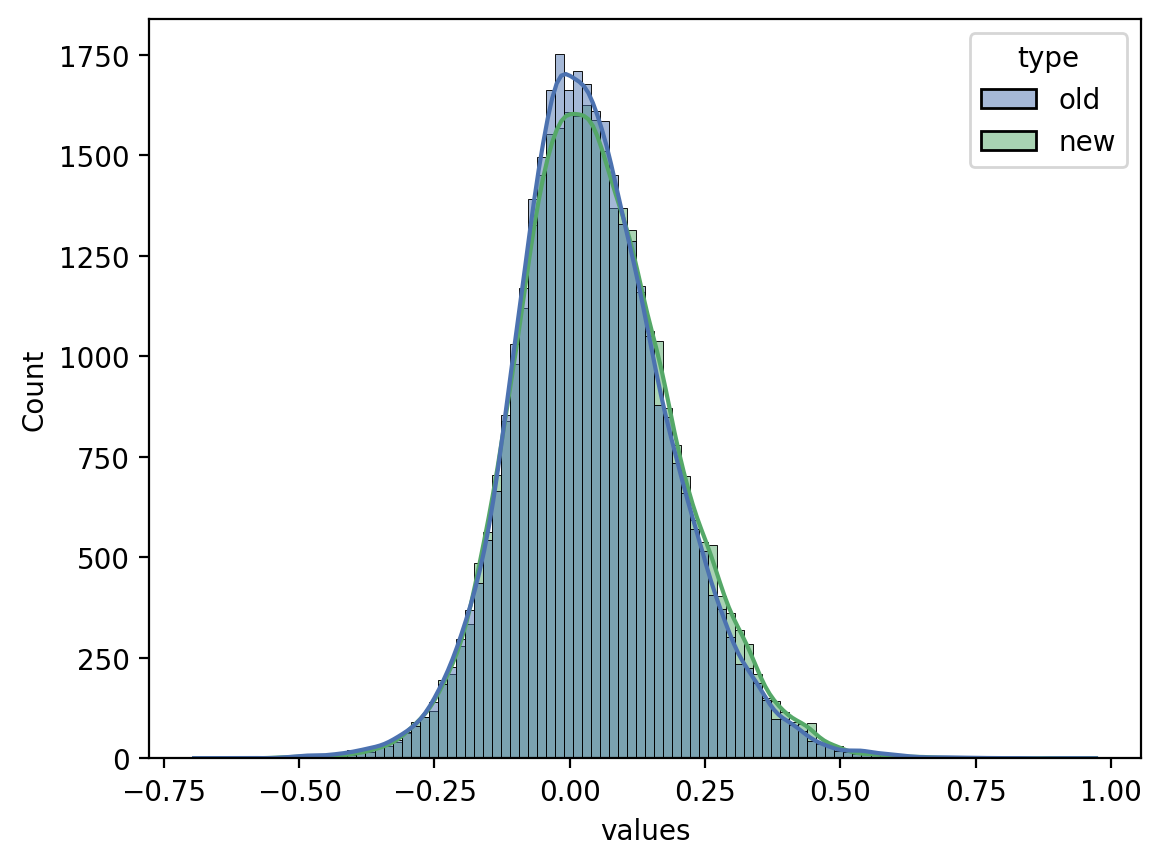

In [29]:
new_cpgs = somage_tcga_dict[0].performance_by_dataset_df['cpg'].unique()
old = somage_tcga_dict_old[0].performance_by_dataset_df.query("cpg in @new_cpgs")['AvP_methyl_pearson'].values
new = somage_tcga_dict[0].performance_by_dataset_df['AvP_methyl_pearson'].values
tp_df = pd.DataFrame({'values': np.concatenate([old, new]), 'type': np.concatenate([np.repeat('old', len(old)), np.repeat('new', len(new))])})
sns.histplot(data = tp_df, x = 'values', hue = 'type', bins = 100)

# ICGC Data

In [3]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


# Feature importances

In [32]:
# for each of the best predicted CpGs 
cv_num = 0
top_cpgs = 50
dataset = 'UCEC'

top_cpgs_list = somage_tcga_dict[cv_num].performance_by_dataset_df.query('dataset == @dataset').sort_values(
    by = 'AvP_methyl_spearman', ascending = False
    ).head(top_cpgs)['cpg']

all_feat_imp_dfs = []
all_feat_imp_by_cat_dfs = []
for cpg in top_cpgs_list:
    # get the model and feature names
    model, feat_names, train_mat, test_mat = (
        somage_tcga_dict[cv_num]
        .get_model_feat_names_train_test(cpg, dataset = dataset)
        )
    feat_imp_df, feat_imp_by_cat_df = somage_tcga_dict[cv_num].get_one_cpg_feat_score_by_cat(
        model, feat_names, train_mat, test_mat, 
        importance_calculator = 'shap', importance_type = "gain"
        )
    feat_imp_df['cpg'] = cpg
    feat_imp_by_cat_df['cpg'] = cpg
    all_feat_imp_dfs.append(feat_imp_df)
    all_feat_imp_by_cat_dfs.append(feat_imp_by_cat_df)
    
all_feat_imp_df = pd.concat(all_feat_imp_dfs).drop_duplicates()
all_feat_imp_by_cat_df = pd.concat(all_feat_imp_by_cat_dfs).drop_duplicates()
all_feat_imp_by_cat_df.rename(columns = {'category': 'Feature type'}, inplace = True)

all_feat_imp_by_cat_df['Feature type'] = all_feat_imp_by_cat_df['Feature type'].map({
    'Nearby locus': 'Specific loci (<50kb distance)',
    'dataset':'Tissue type',
    'matrixqtl_neg_beta': 'Aggregated - somatic-meQTLS', 
    'matrixqtl_pos_beta': 'Aggregated + somatic-meQTLS', 
    'matrixqtl_neg_beta_close': 'Aggregated - somatic-meQTLS (<50kb distance)', 
    'matrixqtl_pos_beta_close': 'Aggregated + somatic-meQTLS (<50kb distance)', 
    'matrixqtl_neg_beta_close_ext': 'Aggregated - somatic-meQTLS (<50kb distance, extended', 
    'matrixqtl_pos_beta_close_ext': 'Aggregated + somatic-meQTLS (<50kb distance, extended)', 
    'nearby': 'Aggregated nearby loci (<50kb distance)',
    'neg_corr': 'Aggregated negatively correlated CpGs',
    'pos_corr': 'Aggregated positively correlated CpGs',
    'pos_corr_ext': 'Aggregated positively correlated CpGs (extended)',
    'neg_corr_ext': 'Aggregated negatively correlated CpGs (extended)',
    'specific_corr_ext': 'Specific correlated CpG (extended)',
    'specific_nested': 'Specific nested feature',
    'specific_tesselated': 'Specific tesselated feature',
    'very_nearby': 'Specific loci (<1kb distance)',
    'specific_neg_beta_close_ext': 'Specific - somatic-meQTLS (<50kb distance, extended)',
    'specific_neg_beta_ext': 'Specific - somatic-meQTLS (extended)',
    'specific_pos_beta_close_ext': 'Specific + somatic-meQTLS (<50kb distance, extended)',
    'specific_pos_beta_ext': 'Specific + somatic-meQTLS (extended)',
})


 98%|===================| 1485/1523 [00:11<00:00]        

# Co-localization soMage

In [ ]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )
mut_feat_icgc = mutation_features.mutationFeatures(
        all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = "./", 
        consortium = 'ICGC', dataset = '', cross_val_num = 0,
        matrix_qtl_dir = icgc_matrix_qtl_dir,
        covariate_fn = icgc_covariate_fn, motif_occurence_df = motif_occurence_df
    )

In [10]:
mut_feat_params = {
    'aggregate': 'Both',
    'num_correl_sites': 500,
    'max_meqtl_sites': 0,
    'nearby_window_size': 50000,
    'extend_amount': 500
}

mut_feat_icgc.create_all_feat_mats(
    cpg_ids = icgc_methyl_age_df_t.columns[5:10].tolist(), 
    aggregate = mut_feat_params['aggregate'],
    num_correl_sites = mut_feat_params['num_correl_sites'], 
    max_meqtl_sites=mut_feat_params['max_meqtl_sites'],
    nearby_window_size = mut_feat_params['nearby_window_size'], 
    extend_amount = mut_feat_params['extend_amount'] 
    )

Finished 0 of 5


In [71]:
methyl_pred = methylation_pred.methylationPrediction(
                mut_feat_store = mut_feat_icgc.mutation_features_store,
                #mut_feat_store_fns = mut_feat_store_fns,
                model_type = "xgboost",
                baseline = "none",
                agg_only = True,
                scale_counts_within_dataset = True,
                predict_with_random_feat = 2,
                illumina_cpg_locs_df = illumina_cpg_locs_df,
                )
methyl_pred.train_all_models()
methyl_pred.apply_all_models()
methyl_pred.save_models_and_preds(out_dir = "/cellar/users/zkoch/methylation_and_mutation/test_out")

['cg00000289', 'cg00000622', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
OUTER: done training 0 CpGs of 5
['cg00000622', 'cg00000289', 'cg00000109', 'cg00000292']
INNER: done training 0 CpGs of 3
['cg00000622', 'cg00000109', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
['cg00000622', 'cg00000109', 'cg00000165', 'cg00000289']
INNER: done training 0 CpGs of 3
['cg00000289', 'cg00000109', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
Predicted methylation for 0 CpGs of 15
Predicted methylation for 10 CpGs of 15
wrote out trained models and predictions to /cellar/users/zkoch/methylation_and_mutation/test_out
